# Matching params to outputs
### Params from https://ars.els-cdn.com/content/image/1-s2.0-S2211124716311986-mmc2.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import copy

import lmfit
from lmfit import Model, Parameters

from scipy.special import i0 as I0
from scipy.interpolate import UnivariateSpline

from tqdm import tqdm

from joblib import Parallel, delayed

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Fitting functions

In [3]:
def tuning_function(x, mu, kappa, fmax, bsl):
    # Von Mises, with kappa the concentration, mu the location, I0 Bessel order 0
    # fmax the firing rate at pref ori, bsl the min firing rate (not the baseline, which was substracted) 
    tf = np.exp((kappa)*np.cos((x-mu)))#/(2*np.pi*I0(kappa))
    tf = norm_data(tf)
    tf *= fmax
    tf += bsl
    return tf

def fit_tc(array, init_kappa):
    x = np.linspace(-np.pi, np.pi, len(array))
    y = array
    
    mod = Model(tuning_function)
    pars = Parameters()
    pars.add_many(('mu', 0, False, 0., np.pi),
                  ('kappa', init_kappa, True,  .1, 60.),
                  ('fmax', np.max(array), False, 0.01, np.max(array)),
                 ('bsl', np.min(array), False, 0.0, np.max(array)))

    out = mod.fit(y, pars, x=x, nan_policy='omit')

    return out.best_values

In [4]:
def nakarushton(x, rmax, c50, b, n):
    nkr = b + (rmax-b) * ((x**n) / (x**n + c50**n))
    return nkr

def fit_nkr(array) :
    x = np.linspace(0, 1, len(array))
    y = np.asarray(array)
    
    mod = Model(nakarushton)
    pars = Parameters()
    
    pars.add_many(('rmax',  np.max(y), True,  0.0,  1.), # TODO maybe move back to 200 as max
              ('c50', .5, True,  0.001, 1.),
              ('b', y.min(), True, 0, .8),
              ('n', 2., True,  1., 100.))
    '''pars.add_many(('rmax',  np.max(y), True,  0.0,  2.),
              ('c50', .5, True,  0.001, 10.),
              ('b', y[0], True, y[0] * .1 + .001, y[-1] * 2 ),
              ('n', 5., True,  1., 250.))'''
    
    out = mod.fit(y, pars, x=x, nan_policy='omit', max_nfev = 2000)
    return out.best_values, np.abs(1-out.residual.var() / np.var(y))

## Helper functions

In [5]:
def norm_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [6]:
def cirvar(arr) :
    cv_thetas = np.linspace(-np.pi, np.pi, len(arr))
    R = np.sum(arr* np.exp(2j*cv_thetas) / np.sum(arr))
    cv = 1 - np.abs(np.real(R))
    return cv

In [7]:
def kappa_to_hwhh(kappa) :
    # # See equation seven https://academic.oup.com/cercor/article/13/3/225/355481#5079220
    # Only works for kappa > 0.3467
    #hwhh = .5*np.arccos(1+ np.log((1+np.exp(-2*kappa))/2)/kappa)
    #hwhh = hwhh * 180 / np.pi
    #hwhh = np.arccos((np.log(.5) + kappa) / kappa) * 180 / np.pi
    hwhh = .5 * np.arccos( (np.log(.5)+kappa)/kappa) * 180 /np.pi
    return hwhh

def hwhh_to_btheta(hwhh) :
    # Quoth https://github.com/NeuralEnsemble/MotionClouds/blob/master/MotionClouds/MotionClouds.py#L246
    # HWHH = np.sqrt(2*Bt**2*np.log(2))
    # HWHH**2 = 2*Bt**2*np.log(2)
    # (HWHH**2)/2 = Bt**2*np.log(2)
    # (HWHH**2)/(2*np.log(2)) = Bt**2
    # Bt = np.sqrt((HWHH**2)/(2*np.log(2)))
    bt = hwhh**2
    bt = bt /2
    bt = bt/np.log(2)
    bt = np.sqrt(bt)
    return bt # in degrees, if the input is in degree

def kappa_to_btheta(kappa) :
    hwhh = kappa_to_hwhh(kappa)
    btheta = hwhh_to_btheta(hwhh)
    return hwhh

## Simulator functions

In [8]:
def make_kernel(kappae, kappai) :
    # making the probabilistic connection patterns
    exc_prob = tuning_function(orientation_space, 0, kappae, 1, 0)
    exc_prob /= np.sum(exc_prob)
    inh_prob = tuning_function(orientation_space, 0, kappai, 1, 0)
    inh_prob /= np.sum(inh_prob)
    
    return exc_prob, inh_prob

In [9]:
def simulate(thetas, kappa_input, 
             Je, Ji, kappae, kappai, Jlgn, kappa_lgn,
             duration, n, 
             idx_recorded_neuron,
             do_RF = False) :
    '''
    This is a wrapper around the single_simulation function, which allows to run multiple 
    sims with different theta_input, in order to build a single neuron TC
    
    A better way would be to record all output possible for all neurons and average out but 
    that's for later :)
    '''
    
    single_neuron_fr = []
    all_outputs = []
    for itheta, theta in enumerate(thetas) :
        output = single_simulation(mu_input = theta, kappa_input = kappa_input,
                                 Je = Je, Ji = Ji, kappae = kappae, kappai = kappai,
                                 Jlgn = Jlgn, kappa_lgn = kappa_lgn,
                                 duration = duration, n = n, do_RF = do_RF)
        single_neuron_fr.append(output['model_outputs'][-1, idx_recorded_neuron])
    
    output['single_neuron_fr'] = single_neuron_fr
    del output['mu_input'] #irrelevant, this is a single run's theta, so can only indice confusion
    del output['model_outputs'] #simpler
    del output['V'] #simpler
    return output

In [10]:
def single_simulation(mu_input, kappa_input, 
                     Je, Ji, kappae, kappai, Jlgn, kappa_lgn,
                     duration, n, do_RF = False) :
    
    output = {'mu_input' : mu_input, 'kappa_input' : kappa_input,
              'Je' : Je, 'Ji' : Ji, 'kappae' : kappae, 'kappai' : kappai,
              'Jlgn' : Jlgn, 'kappa_lgn' : kappa_lgn,
              'duration' : duration, 'n' : n, 'do_RF' : do_RF}
    
    # Initializes the array of inputs
    model_inputs = tuning_function(orientation_space,mu_input, 
                                  kappa_input, 1,0)
    
    if do_RF :
        # Multiplies the "LGN" input with a receptive field
        RF = tuning_function(orientation_space, mu_input, kappa_lgn, 1, 0)
        model_inputs *= RF
    
    # Reshaping
    model_inputs = np.repeat(model_inputs, duration, axis = -1)
    model_inputs = model_inputs.reshape((n, duration)).T
    
    # Kernel of response by probability distributions
    exc_prob, inh_prob = make_kernel(kappae, kappai)
    kernel = exc_prob*Je - inh_prob*Ji
    fourier_j_ctx = np.fft.fft(kernel*.5)

    # Make the movie
    model_outputs = Rrest * np.ones((duration, n))
    
    # Voltage of the model
    V = Rrest / alpha * np.ones((1,n))
    
    # Main iteration
    for it in range(1, duration) :
        Vlgn = Jlgn * model_inputs[it-1,:] # Voltage of input

        fourier_output = np.fft.fft(model_outputs[it-1,:])/n # transforms the output into fourier
        Vctx = n*np.real(np.fft.ifft(fourier_j_ctx*fourier_output)) # and makes it the output
        V = V+(-V + Vlgn + Vctx)*(dt/tau) # keeping track of membrane potentials

        model_outputs[it,:] = np.round(alpha * np.maximum(V, 0)* 10000)/10000 # and rectifcation
        
    output['model_inputs'] = model_inputs[:10,:] # we just keep the beginning
    output['model_outputs'] = model_outputs
    output['V'] = V
    return output

## Data analysis functions

In [11]:
def filter_nkr_array(nkr_array, dico_bounds, r2_min = .9, verbose = True) :
    # Filters a NKR array by a list of dictionnaries, shape of 
    # 'var' : key , 'min' : 0, 'max' : 1
    #ilt_array = copy.copy(nkr_array)
    
    '''for filt in dico_bounds :
        for i, el in enumerate(filt_array) :
            if el['nkr_fit'][0][filt['var']] > filt['min'] :
                if el['nkr_fit'][0][filt['var']] < filt['max'] :
                    if el['nkr_fit'][1] >= r2_min: 
                        print(el['nkr_fit'][0]['b'])
                        pass
                    else :
                        del filt_array[i]
                else :
                    del filt_array[i]
            else :
                del filt_array[i]
        print(i)
    if verbose : print('In size : %s -- Out size : %s' % (len(nkr_array), len(filt_array)))
    return filt_array'''
    lst = copy.copy(nkr_array)
    for bounds in dico_bounds :
        lst= [x for x in lst if bounds['min'] <= x['nkr_fit'][0][bounds['var']] <= bounds['max']]
    lst = [x for x in lst if x['nkr_fit'][1] >= r2_min]
    if verbose : print('In size : %s -- Out size : %s' % (len(nkr_array), len(lst)))
    return lst

## Plotting functions

In [12]:
def plot_kernel(Je, Ji, kappae, kappai) :
    fig, axs = plt.subplots(figsize = (10,5), ncols = 2)

    exc_prob, inh_prob = make_kernel(Je, Ji, kappae, kappai)
    axs[0].plot(orientation_space, exc_prob)
    axs[0].plot(orientation_space, inh_prob)
    axs[0].set_title('Proba distribution')

    axs[1].plot(exc_prob*Je - inh_prob*Ji)
    axs[1].set_title('Cortical kernel')
    plt.show()

In [13]:
def plot_I_O_tcs(outputs) :
    # plots the TCs of the input and the TCs of the output
    # Has to be organized in the length of kappa_inputs
    fig, axs = plt.subplots(figsize = (12,5), ncols = 2)
    cols = plt.cm.viridis(np.linspace(0, 1., len(kappa_inputs)))
    
    hwhh_inputs = kappa_to_hwhh(kappa_inputs)
    for i0, _ in enumerate(outputs) :
        # Hack of the year
        if i0 == 0 or i0 == len(kappa_inputs)-1 or i0 == len(kappa_inputs)//2 :
            label = '%.2f' %hwhh_inputs[i0]
        else :
            label = '_nolabel_' #turns out everything with an underscore is skipped
            
        axs[0].plot(orientation_space, outputs[i0]['model_inputs'][1,:], color = cols[i0], 
                   label = label)
        axs[1].plot(thetas, outputs[i0]['single_neuron_fr'], color = cols[i0])
        
    axs[0].legend(title = 'HWHH')
    axs[0].set_title('Input TC to the model')
    axs[1].set_title('Output TC of the model')
    
    return fig, axs

In [14]:
def plot_I_O_neurometric(outputs, ax, color, label = '_nolabel_',
                        metric = 'hwhh') :
    y = []
    for sim in outputs :
        if metric == 'hwhh' :
            kappa = fit_tc(sim['single_neuron_fr'], init_kappa = sim['kappa_input'])['kappa']
            y.append(kappa_to_hwhh(kappa))
        elif metric == 'cv' :
            y.append(cirvar(sim['single_neuron_fr']))
        
    ax.plot(kappa_to_hwhh(kappa_inputs), y, color = color, label = label)
    
    return ax

# Default parameters and a single run

In [15]:
n = 128# number of neurons
duration = 150 # ms
orientation_space = np.linspace(-np.pi, np.pi, n)

alpha = 10.6 #gain of voltage to FR
Rrest = 0 # resting firing rate
tau = 10.8 # membrane time constant (ms)
dt = 1 # simulation step time

Jlgn = 9.57
Je, Ji = 1.71, 2.0178 # see notebook on notability for the maths
#Je, Ji = 0,0
kappae, kappai  = 1.59, 1.16
kappa_lgn = 1.56

In [16]:
metric = 'cv' # cv or hwhh, depending on what we're measuring for the output TC

In [17]:
N_thetas = 32 # number of oriented stims, to build a single neuron tuning curve
offset = np.pi/12 # avoid border effects
thetas = np.linspace(-np.pi+offset, np.pi-offset, N_thetas)

## Multiple runs, parameters scanning

In [18]:
n_scans = 200

#scan_jes = np.linspace(1., 3., n_scans)
#scan_jis = np.linspace(1.5, 3.5, n_scans)
scan_kappaes = np.linspace(.35, 7., n_scans)
scan_kappais = np.linspace(.35, 7., n_scans)

kappa_inputs = np.linspace(22.85, .7625, 20) # 6 to 36 ° of btheta

#shape is inputs, kappaes, kappais
iter_prod = list(itertools.product(range(len(kappa_inputs)),
                                   range(n_scans),
                                   range(n_scans)))

In [19]:
save = False
load = True

In [20]:
if not load :
    output_sims = Parallel(n_jobs = -1)(delayed(simulate)(
                                thetas = thetas, kappa_input = kappa_inputs[it[0]],
                                Je = Je, Ji = Ji,
                                kappae = scan_kappaes[it[1]], kappai = scan_kappais[it[2]],
                                Jlgn = Jlgn, kappa_lgn = None, duration = duration, n = n,
                                idx_recorded_neuron = n//2,
                                do_RF = False)
                for it in tqdm(iter_prod, desc = 'Simulating', total = len(iter_prod)))

In [21]:
if save :
    np.save('./data/final_rec_sims.npy', output_sims)

In [22]:
if load :
    output_sims = np.load('./data/final_rec_sims.npy', allow_pickle = True)

## Rebuilding the Naka-Rushtons

In [23]:
if not load:
    nkr_array = []
    failed_fits = 0
    for this_scan_kappae in tqdm(scan_kappaes, 'Rebuilding the PRFs') :
        for this_scan_kappai in scan_kappais :
            # Filtering the outputs
            outputs = [x for x in output_sims if x['kappae'] == this_scan_kappae and
                                                  x['kappai'] == this_scan_kappai]
            sorted_out = sorted(outputs, key = lambda d : d['kappa_input'], reverse = True)

            try :
                y = []
                for sim in sorted_out :
                    if metric == 'hwhh' :
                        kappa = fit_tc(sim['single_neuron_fr'], init_kappa = sim['kappa_input'])['kappa']
                        y.append(kappa_to_hwhh(kappa))
                    elif metric == 'cv' :
                        y.append(cirvar(sim['single_neuron_fr']))
    
                fitted_nkr = fit_nkr(y)

                nkr_array.append({'nkr_raw' : y,
                                 'nkr_fit' : fitted_nkr,
                                 'kappae' : this_scan_kappae,
                                 'kappai' : this_scan_kappai,
                                 'metric' : metric})
            except TypeError :
                failed_fits +=1
                
    np.save('./data/final_nkrs.npy', nkr_array)

In [24]:
if load :
    nkr_array = np.load('./data/final_nkrs.npy', allow_pickle = True)
    nkr_array = list(nkr_array)
    failed_fits = 0

In [25]:
print('Failed to fit %s naka rushtons' % failed_fits)

Failed to fit 0 naka rushtons


### Plotting all the sims

### Plotting all the fits parameters

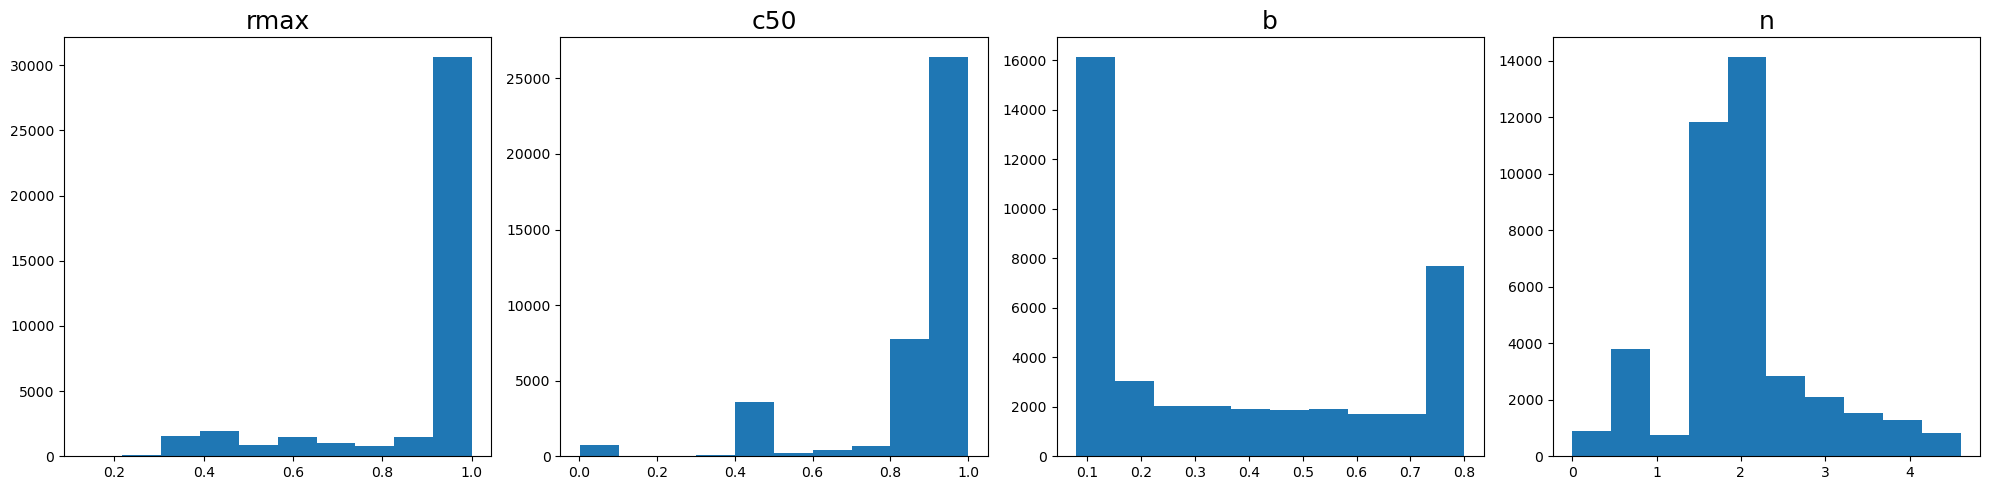

In [26]:
fig, axs = plt.subplots(figsize = (20,5), ncols = 4)
keys = ['rmax', 'c50', 'b', 'n']
boundaries = []
for iax, ax in enumerate(axs) :
    vals = [x['nkr_fit'][0][keys[iax]] for x in nkr_array]
    if keys[iax] == 'n' :
        vals = np.log(vals)
    ax.hist(vals)
    ax.set_title(keys[iax], fontsize = 18)
    boundaries.append((np.min(vals), np.max(vals)))
fig.tight_layout()
plt.show()

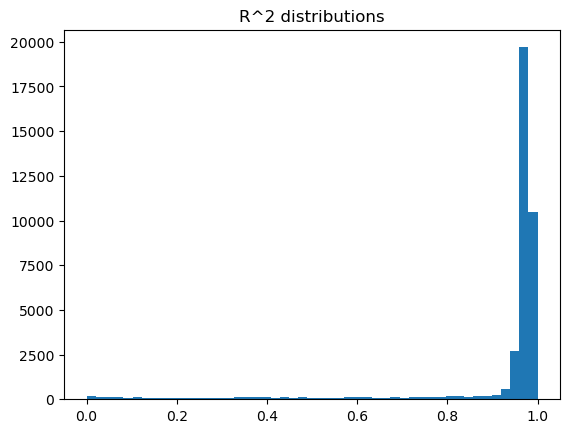

In [27]:
rs = [x['nkr_fit'][1] for x in nkr_array]
plt.hist(rs, bins = np.linspace(0, 1, 50))
plt.title('R^2 distributions')
plt.show()

## Looking at params in, params out

In [28]:
dico_bounds = [{'var' : 'rmax', 'min' : 0, 'max' : np.inf},
              {'var' : 'c50', 'min' : 0, 'max' : np.inf},
              {'var' : 'b', 'min' : 0, 'max' : np.inf},
              {'var' : 'n', 'min' : 0, 'max' : np.inf}]
filtered_array = filter_nkr_array(nkr_array, dico_bounds = dico_bounds, r2_min = .95)

In size : 40000 -- Out size : 33284


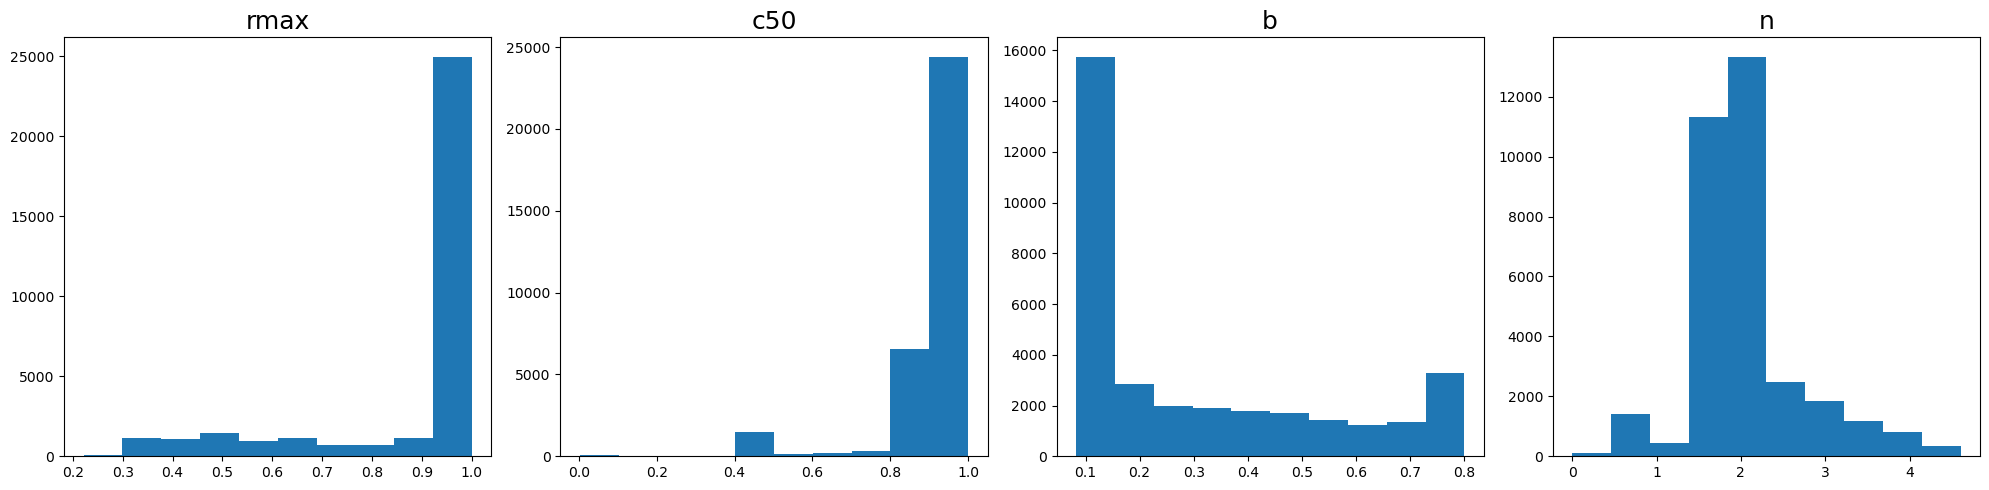

In [29]:
fig, axs = plt.subplots(figsize = (20,5), ncols = 4)
keys = ['rmax', 'c50', 'b', 'n']
boundaries = []
for iax, ax in enumerate(axs) :
    vals = [x['nkr_fit'][0][keys[iax]] for x in filtered_array]
    if keys[iax] == 'n' :
        vals = np.log(vals)
    ax.hist(vals)
    ax.set_title(keys[iax], fontsize = 18)
    boundaries.append((np.min(vals), np.max(vals)))
fig.tight_layout()
plt.show()

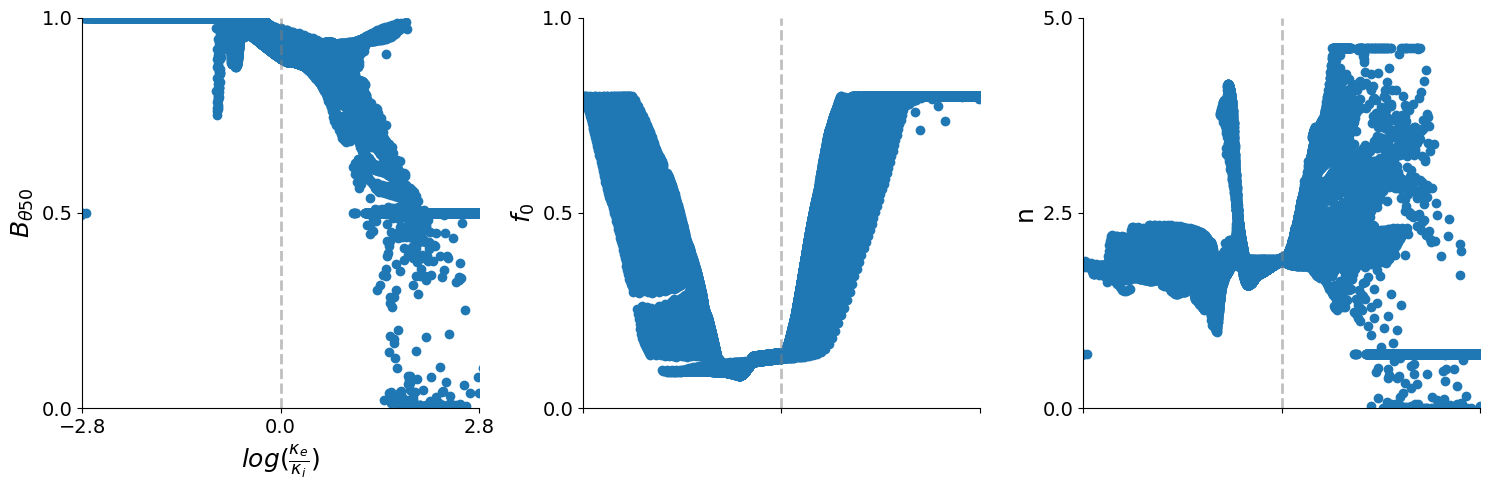

In [30]:
# correlating kappae/kappai
fig, axs = plt.subplots(figsize = (15,5), ncols = 3)
keys = ['c50', 'b', 'n']
names = [r'$B_{\theta50}$', r'$f_0$', 'n']
for iax, ax in enumerate(axs) :
    
    kappai_values = [x['kappai'] for x in filtered_array]
    kappae_values = [x['kappae'] for x in filtered_array]
    
    fit_values = [x['nkr_fit'][0][keys[iax]] for x in filtered_array]
    if keys[iax] == 'n' :
        fit_values = np.log(fit_values)
    ax.scatter(np.log(np.asarray(kappai_values)/np.asarray(kappae_values)),
               fit_values)
    
    ax.axvline(0, color = 'gray', linestyle = '--', lw = 2, alpha = .5)
    
    if iax == 0 : 
        ax.set_xlabel(r'$log(\frac{\kappa_e}{\kappa_i})$', fontsize = 18)
        
    ax.set_ylabel(names[iax], fontsize = 18)
    
    ax.set_xlim(-2.8, 2.8)
    ax.set_xticks([-2.8, 0, 2.8])
    
    if iax > 0 :
        ax.set_xticklabels([])
        
    if iax == 0 :
        ax.set_ylim(0,1)
        ax.set_yticks([0, .5, 1.])
    if iax == 1 :
        ax.set_ylim(0,1)
        ax.set_yticks([0, .5, 1.])
    if iax == 2 :
        ax.set_ylim(0,5)
        ax.set_yticks([0, 2.5, 5.])
        
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
fig.tight_layout()
plt.show()

In [31]:
xs = np.log(np.asarray(kappai_values)/np.asarray(kappae_values))
ys = fit_values

arr = np.array((xs,ys))

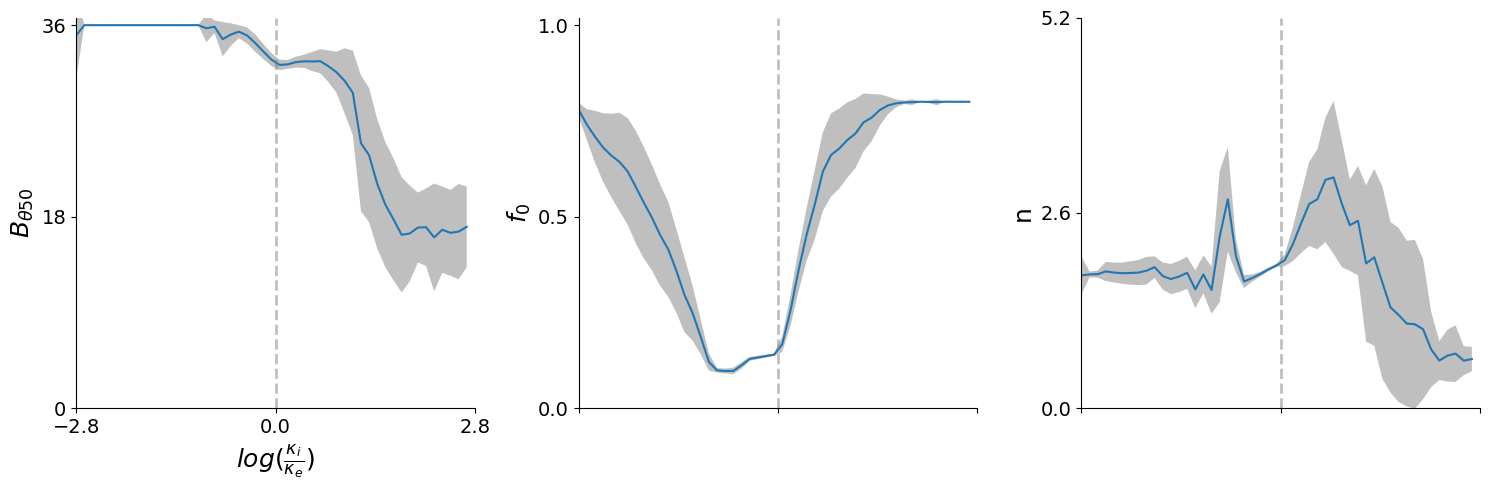

In [32]:
# correlating kappae/kappai
fig, axs = plt.subplots(figsize = (15,5), ncols = 3)
keys = ['c50', 'b', 'n']
names = [r'$B_{\theta50}$', r'$f_0$', 'n']
for iax, ax in enumerate(axs) :
    
    kappai_values = [x['kappai'] for x in filtered_array]
    kappae_values = [x['kappae'] for x in filtered_array]
    
    fit_values = [x['nkr_fit'][0][keys[iax]] for x in filtered_array]
    if keys[iax] == 'n' :
        fit_values = np.log(fit_values)
        
    xs = np.log(np.asarray(kappai_values)/np.asarray(kappae_values))
    ys = fit_values
    arr = np.array((xs,ys))
    yhist, xhist = np.histogram(arr, bins = np.linspace(-2.8, 2.8, 50))
    arr_mean, arr_std = [], []
    for ix in range(xhist.shape[0]-1) :
        where_dat = np.where((arr[0,:] > xhist[ix]) & (arr[0,:] <= xhist[ix+1]))
        arr_mean.append(np.mean(arr[1,where_dat]))
        arr_std.append(np.std(arr[1,where_dat]))
        
    arr_mean = np.asarray(arr_mean)
    arr_std = np.asarray(arr_std)
    
    ax.plot(xhist[:-1], arr_mean)
    ax.fill_between(xhist[:-1],
                    arr_mean + arr_std, arr_mean - arr_std,
                    facecolor = 'gray', edgecolor = None, alpha = .5,
                    label = r'Learned B$_\theta$ x $\theta$')

    
    ax.axvline(0, color = 'gray', linestyle = '--', lw = 2, alpha = .5)
    
    if iax == 0 : 
        ax.set_xlabel(r'$log(\frac{\kappa_i}{\kappa_e})$', fontsize = 18)
        
    ax.set_ylabel(names[iax], fontsize = 18)
    
    ax.set_xlim(-2.8, 2.8)
    ax.set_xticks([-2.8, 0, 2.8])
    
    if iax > 0 :
        ax.set_xticklabels([])
        
    if iax == 0 :
        ax.set_ylim(0,1.02)
        ax.set_yticks([0, .5, 1.])
        ax.set_yticklabels([0, 18, 36])
    if iax == 1 :
        ax.set_ylim(0,1.02)
        ax.set_yticks([0, .5, 1.])
    if iax == 2 :
        ax.set_ylim(0,5.2)
        ax.set_yticks([0, 2.6, 5.2])
        
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
fig.tight_layout()
fig.savefig('./figs/paramsims.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight', transparent = True)
plt.show()

# As images instead

/tmp/ipykernel_30483/899921644.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


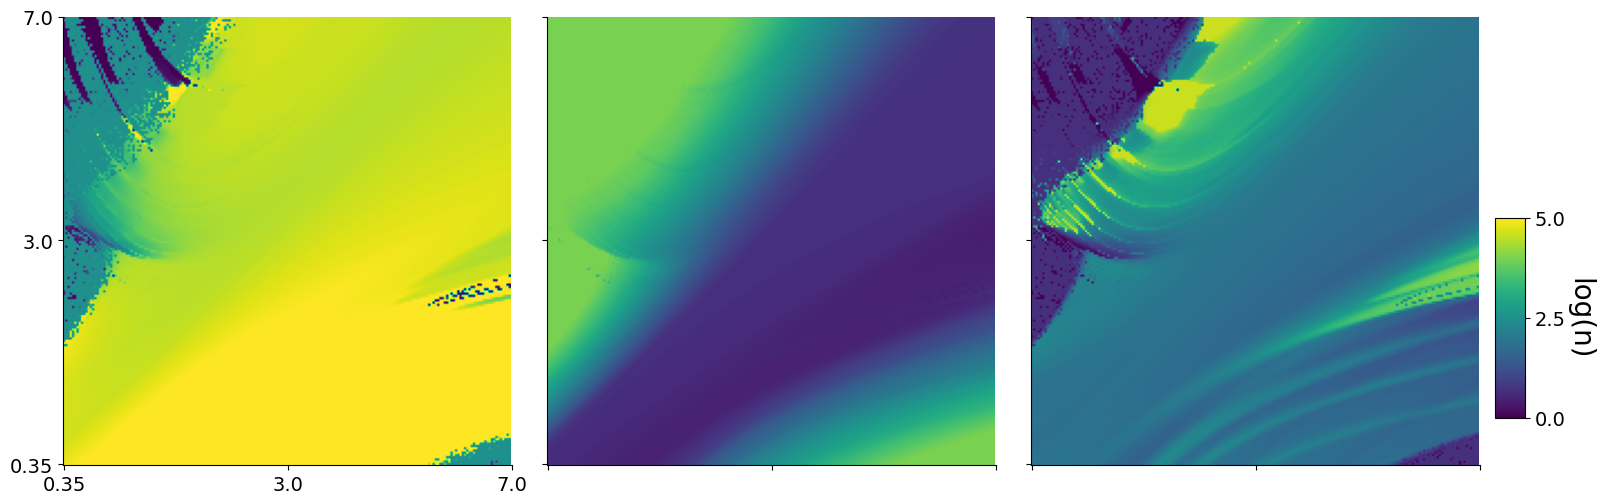

In [33]:
# correlating kappae/kappai
fig, axs = plt.subplots(figsize = (15,5), ncols = 3)
keys = ['c50', 'b', 'n']
names = [r'$B_{\theta50}$', r'$f_0$', 'n']
vmins = [0, 0, 0]
vmaxs = [1,1,5]

for iax, ax in enumerate(axs) :
    img_params = np.zeros((len(scan_kappais), len(scan_kappaes)))
    count_array = np.zeros_like(img_params)
    for el in nkr_array :
        idx_kappai = np.where(scan_kappais == el['kappai'])[0]
        idx_kappae = np.where(scan_kappaes == el['kappae'])[0]
        img_params[idx_kappai, idx_kappae] += el['nkr_fit'][0][keys[iax]]
        count_array[idx_kappai, idx_kappae] +=1
    img_params /= count_array # cheap trick to make the array a mean
        
    if keys[iax] == 'n' :
        img_params = np.log(img_params)
        
    
    ims = ax.imshow(img_params, cmap = plt.cm.viridis,
                   vmin = vmins[iax], vmax = vmaxs[iax], 
                   origin = 'lower')
    
    
    
    ax.set_xticks([0, len(scan_kappais)//2, len(scan_kappais)])
    ax.set_yticks([0, len(scan_kappais)//2, len(scan_kappais)])
    if iax == 0 :
        ax.set_xticklabels([np.min(scan_kappais),
                            np.max(scan_kappais)//2,
                            np.max(scan_kappais)])
        ax.set_yticklabels([np.min(scan_kappais),
                            np.max(scan_kappais)//2,
                            np.max(scan_kappais)])
    else :
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
    if iax == 2 :
        cax = fig.add_axes([ax.get_position().x1+0.1, # offset from the right of the axis
                                ax.get_position().y0+0., #bottom of the colorbar
                                0.02, #width of the colorbar
                                .4]) #height of the colorbar
        cb = fig.colorbar(ims, cax = cax, ticks = np.linspace(0, 5, 3))
        cb.ax.set_yticklabels(np.round(np.linspace(0, 5, 3), 1))

        cax.set_ylabel('log(n)', rotation = 270, labelpad = 20,
                      fontsize = 20)
        cb.ax.tick_params(labelsize = 14)
        
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
fig.tight_layout()
fig.savefig('./figs/imgsim.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight', transparent = True)
plt.show()

In [34]:
img_params.shape

(200, 200)

In [35]:
np.linspace(0, 35, 4)

array([ 0.        , 11.66666667, 23.33333333, 35.        ])

0.001 1.0


/tmp/ipykernel_30483/1720430800.py:24: UserWarning: linewidths is ignored by contourf
  cs = ax.contourf(img_params, levels = np.linspace(0.0, vmaxs[iax], nlevels, endpoint = True),


0.07914091144386037 0.8
0.0 4.605170185988092


/tmp/ipykernel_30483/1720430800.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


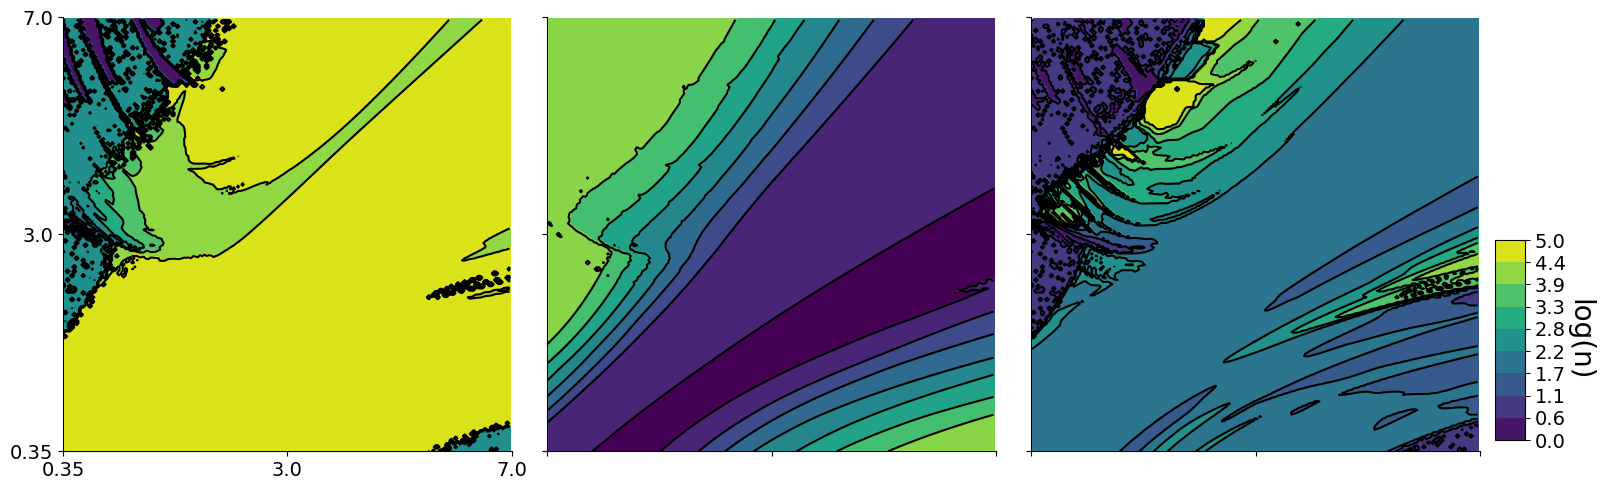

In [36]:
# correlating kappae/kappai
fig, axs = plt.subplots(figsize = (15,5), ncols = 3)
keys = ['c50', 'b', 'n']
names = [r'$B_{\theta50}$', r'$f_0$', 'n']
vmins = [0.001, 0.07, 0]
vmaxs = [1,1,5]
nlevels = 10

for iax, ax in enumerate(axs) :
    img_params = np.zeros((len(scan_kappais), len(scan_kappaes)))
    count_array = np.zeros_like(img_params)
    for el in nkr_array :
        idx_kappai = np.where(scan_kappais == el['kappai'])[0]
        idx_kappae = np.where(scan_kappaes == el['kappae'])[0]
        img_params[idx_kappai, idx_kappae] += el['nkr_fit'][0][keys[iax]]
        count_array[idx_kappai, idx_kappae] +=1
    img_params /= count_array # cheap trick to make the array a mean
        
    if keys[iax] == 'n' :
        img_params = np.log(img_params)
        
    print(img_params.min(), img_params.max())

    cs = ax.contourf(img_params, levels = np.linspace(0.0, vmaxs[iax], nlevels, endpoint = True), 
                    cmap = plt.cm.viridis,
                   vmin = vmins[iax], vmax = vmaxs[iax], 
                   origin = 'lower', zorder = 30, linewidths = 0.5)
    cs2 = ax.contour(img_params, cs.levels, colors='k', zorder = 50)

    
    
    
    ax.set_xticks([0, len(scan_kappais)//2, len(scan_kappais)])
    ax.set_yticks([0, len(scan_kappais)//2, len(scan_kappais)])
    if iax == 0 :
        ax.set_xticklabels([np.min(scan_kappais),
                            np.max(scan_kappais)//2,
                            np.max(scan_kappais)])
        ax.set_yticklabels([np.min(scan_kappais),
                            np.max(scan_kappais)//2,
                            np.max(scan_kappais)])
    else :
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
    if iax == 2 :
        cax = fig.add_axes([ax.get_position().x1+0.1, # offset from the right of the axis
                                ax.get_position().y0+0., #bottom of the colorbar
                                0.02, #width of the colorbar
                                .4]) #height of the colorbar
        cb = fig.colorbar(cs, cax = cax, ticks = np.linspace(0, 5, nlevels))
        cb.ax.set_yticklabels(np.round(np.linspace(0, 5, nlevels), 1))

        cax.set_ylabel('log(n)', rotation = 270, labelpad = 20,
                      fontsize = 20)
        cb.ax.tick_params(labelsize = 14)
        
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
fig.tight_layout()
fig.savefig('./figs/contoursim.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight', transparent = True)
plt.show()

# Making some cool NKRs

In [37]:
dico_bounds = [{'var' : 'rmax', 'min' : 0, 'max' : np.inf},
              {'var' : 'c50', 'min' : 0, 'max' : np.inf},
              {'var' : 'b', 'min' : 0., 'max' : .25},
              {'var' : 'n', 'min' : 0, 'max' : 3}]
filtered_array_ultratuned = filter_nkr_array(nkr_array, dico_bounds = dico_bounds, r2_min = .9)
np.save('./data/single_ultratuned.npy', filtered_array_ultratuned)

In size : 40000 -- Out size : 42


In [38]:
dico_bounds = [{'var' : 'rmax', 'min' : 0, 'max' : np.inf},
              {'var' : 'c50', 'min' : 0.5, 'max' : .8},
              {'var' : 'b', 'min' : 0.2, 'max' : .6},
              {'var' : 'n', 'min' : 0, 'max' : np.inf}]
filtered_array_untuned = filter_nkr_array(nkr_array, dico_bounds = dico_bounds, r2_min = .9)
np.save('./data/single_untuned.npy', filtered_array_untuned)

In size : 40000 -- Out size : 111


In [39]:
dico_bounds = [{'var' : 'rmax', 'min' : 0, 'max' : .7},
              {'var' : 'c50', 'min' : 0, 'max' : np.inf},
              {'var' : 'b', 'min' : 0.4, 'max' : .5},
              {'var' : 'n', 'min' : 0, 'max' : 5}]
filtered_array_tuned = filter_nkr_array(nkr_array, dico_bounds = dico_bounds, r2_min = .9)
np.save('./data/single_tuned.npy', filtered_array_tuned)

In size : 40000 -- Out size : 176


dico_bounds = [{'var' : 'rmax', 'min' : 0, 'max' : np.inf},
              {'var' : 'c50', 'min' : 0.5, 'max' : np.inf},
              {'var' : 'b', 'min' : 0.3, 'max' : .4},
              {'var' : 'n', 'min' : 0, 'max' : np.inf}]
filtered_array_untuned = filter_nkr_array(nkr_array, dico_bounds = dico_bounds, r2_min = .9)
np.save('./data/f2.npy', filtered_array_untuned)

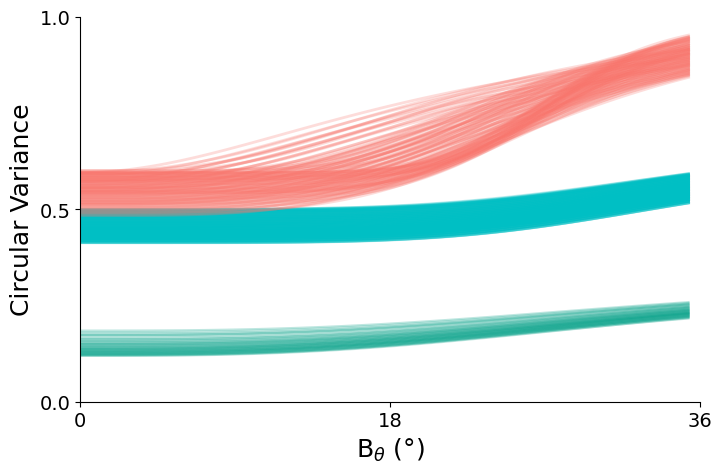

In [40]:
fig, ax = plt.subplots(figsize = (8,5))

btheta_inputs = kappa_to_btheta(kappa_inputs)-kappa_to_btheta(kappa_inputs[0]) # btheta = 0° is not mathematically defined
btheta_inputs_interp = np.linspace(btheta_inputs.min(), btheta_inputs.max(), 100)

for el in filtered_array_tuned:
    ax.plot(btheta_inputs_interp, 
            nakarushton(x = np.linspace(0, 1, 100), **el['nkr_fit'][0]),
        alpha = .25, color = '#00BFC4', lw = 2)
    
for el in filtered_array_untuned:
    ax.plot(btheta_inputs_interp, 
            nakarushton(x = np.linspace(0, 1, 100), **el['nkr_fit'][0]),
           alpha = .25, color = '#F8766D', lw = 2)

for el in filtered_array_ultratuned:
    ax.plot(btheta_inputs_interp, 
            nakarushton(x = np.linspace(0, 1, 100), **el['nkr_fit'][0]),
        alpha = .25, color = '#00A087FF')
    
ax.set_ylim(0,1)
ax.set_xlim(0, 36)
ax.set_yticks([0, .5, 1.])
ax.set_xticks([0, 18, 36])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel(r'B$_\theta$ (°)', fontsize = 18)
ax.set_ylabel('Circular Variance', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=14)
fig.savefig('./figs/nkrs.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight', transparent = True)
plt.show()

In [41]:
ns, c50s, bs = [], [], []
for el in filtered_array_tuned:
    ns.append(el['nkr_fit'][0]['n'])
    c50s.append(el['nkr_fit'][0]['c50'])
    bs.append(el['nkr_fit'][0]['b'])
    
print('tuned')
print(np.percentile(ns, 5), np.percentile(ns, 95))
print(np.percentile(c50s, 5), np.percentile(c50s, 95))
print(np.percentile(bs, 5), np.percentile(bs, 95))

ns, c50s, bs = [], [], []
for el in filtered_array_untuned:
    ns.append(el['nkr_fit'][0]['n'])
    c50s.append(el['nkr_fit'][0]['c50'])
    bs.append(el['nkr_fit'][0]['b'])
    
print('--')
print('untuned')
print(np.percentile(ns, 5), np.percentile(ns, 95))
print(np.percentile(c50s, 5), np.percentile(c50s, 95))
print(np.percentile(bs, 5), np.percentile(bs, 95))
    
ns, c50s, bs = [], [], []
for el in filtered_array_ultratuned:
    ns.append(el['nkr_fit'][0]['n'])
    c50s.append(el['nkr_fit'][0]['c50'])
    bs.append(el['nkr_fit'][0]['b'])
    
    
print('--')
print('ultratuned')
print(np.percentile(ns, 5), np.percentile(ns, 95))
print(np.percentile(c50s, 5), np.percentile(c50s, 95))
print(np.percentile(bs, 5), np.percentile(bs, 95))

tuned
4.452548942900275 4.9809326545292105
0.9999999994781497 0.9999999999730582
0.4178235418523564 0.49435029159220356
--
untuned
2.2505064947573588 8.020727327572391
0.6395662831153264 0.797117096330217
0.49754712468087875 0.5939941992972202
--
ultratuned
2.6918335599681957 2.9769531895556156
0.9999999956201993 0.9999999999999999
0.12065426939513146 0.17625674708316186
